In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Logistic regression with the German credit dataset ...

In [2]:
data = np.genfromtxt("./fiducial_samples/german.data-numeric")
x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)

x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)

x /= (x_max - x_min)
x = 2.0 * x - 1.0

x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

In [95]:
n = x.shape[0]
d = x.shape[1]

def log_like(params, data=y, covariates=x):
    
    tau = params[0]
    lam = params[1:d+1]
    beta = params[d+1:]
    
    f = jnp.matmul(covariates, tau * beta * lam)
    
    return jnp.sum(jax.scipy.stats.bernoulli.logpmf(k=data, p=jax.nn.sigmoid(f)))

def log_prior(params):
    
    tau = params[0]
    lam = params[1:d+1]
    beta = params[d+1:]
    logp_tau = jax.scipy.stats.gamma.logpdf(x=tau, a=0.5, scale=1.0/0.5)
    logp_lam = jnp.sum(jax.scipy.stats.gamma.logpdf(x=lam, a=0.5, scale=1.0/0.5))
    logp_beta = jnp.sum(jax.scipy.stats.norm.logpdf(x=beta, loc=0, scale=1.0))
    
    return logp_tau + logp_lam + logp_beta

def prior_rvs(key, N):
    
    tau = 0.5 * jax.random.gamma(key, a=0.5, shape=(N,))
    lam = 0.5 * jax.random.gamma(key, a=0.5, shape=(N, d))
    beta = jax.random.normal(key, shape=(N, d))
    
    return jnp.concatenate([tau.reshape(N, 1), lam, beta], axis=1)

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_prior)

prior_init = prior_rvs(jax.random.PRNGKey(0), 10)

lower = [0 for i in range(d + 1)]
for i in range(d):
    lower.append(-1e9)
upper = [1e9 for i in range(2 * d + 1)]

print(np.array([lower, upper]))

print(lower)
print(upper)

(10, 51)
[[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00
   0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -1.e+09
  -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09
  -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09
  -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09 -1.e+09]
 [ 1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09
   1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09
   1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09
   1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09
   1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09
   1.e+09  1.e+09  1.e+09  1.e+09  1.e+09  1.e+09]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1000000000.0, -1000000000.0, -1000000000.0, -1000000000.0, -10000000

In [91]:
llk = jax.vmap(lambda x: log_like(x))(prior_init)
lpr = jax.vmap(lambda x: log_prior(x))(prior_init)
print(jnp.shape(llk))
print(jnp.shape(lpr))

(10,)
(10,)


In [92]:
truth_df = pd.read_csv('./fiducial_samples/german_credit_nuts_samples.csv', index_col=0)
truth_x = np.empty((4000, n))

print(truth_df.columns)

truth_x[:, 0] = truth_df["('posterior', 'tau')"]
for i in range(d):
    truth_x[:, i] = truth_df["('posterior', 'lam[{0}]', {1})".format(i, i)]
for i in range(d):
    truth_x[:, i] = truth_df["('posterior', 'beta[{0}]', {1})".format(i, i)]
    
np.savetxt('./fiducial_samples/german_credit_nuts_samples.txt', truth_x)

Index(['chain', 'draw', '('posterior', 'beta[0]', 0)',
       '('posterior', 'beta[10]', 10)', '('posterior', 'beta[11]', 11)',
       '('posterior', 'beta[12]', 12)', '('posterior', 'beta[13]', 13)',
       '('posterior', 'beta[14]', 14)', '('posterior', 'beta[15]', 15)',
       '('posterior', 'beta[16]', 16)',
       ...
       '('sample_stats', 'perf_counter_diff')', '('sample_stats', 'energy')',
       '('sample_stats', 'n_steps')', '('sample_stats', 'perf_counter_start')',
       '('sample_stats', 'step_size_bar')',
       '('sample_stats', 'process_time_diff')',
       '('sample_stats', 'step_size')', '('sample_stats', 'diverging')',
       '('sample_stats', 'max_energy_error')', '('sample_stats', 'lp')'],
      dtype='object', length=1066)


In [93]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0., 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = None
trainable_qw = False # Just leave this for now.
sgd_steps = 0
gamma = 0
knots_trainable = None
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = None
NERCOME = True
t_ess = 0.5

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.0
frac_validate = 0.2
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 0.5
reg2 = 0.5
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 92
grad_norm_thresh = 0.5
max_dla_line_steps = 10
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
grad_free_dla = False
dla_beta_thresh = 0.5
latent_dla = True
rel_fish_tol = 1e-2
abs_fish_tol = 1e-3
maxknot = False

max_dla_iter = 20

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

cull_lowp_tol = 1e-2

Now we can run our 10d Gaussian example.

In [94]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             prior_rvs_func=prior_rvs,
                             init_samples=prior_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             cull_lowp_tol=cull_lowp_tol,
                             maxknot=maxknot)

Inference mode is DLA. Maximum beta is set to 1.
Number of particles that did not get updated by prior DLA: 0
Mean number of prior DLA line search iterations: 1.4
Mean step size: 0.0011123218573629856
Samples: [[ 4.52518731e-01  3.20115983e-01  3.68341804e-02  6.21715605e-01
   1.16687454e-02  1.70505881e-01  3.01261246e-01 -1.01331644e-01
   2.24628612e-01  2.87646204e-01  6.24073185e-02  4.63567972e-01
   1.74551755e-01  1.94244921e-01  7.94433832e-01  1.67057708e-01
   1.43041706e+00  1.87857658e-01  4.47261065e-01 -2.53141373e-01
   5.42288534e-02  5.15283287e-01  3.68581176e-01  1.01380420e+00
   1.93280503e-01  4.18531299e-01 -6.94406807e-01  1.70843378e-01
  -5.18151402e-01 -3.80372368e-02  2.66612947e-01 -1.61164391e+00
   6.88421488e-01 -1.31681681e+00  1.56301808e+00  6.48537055e-02
  -8.48281562e-01  2.18513989e+00 -4.66277182e-01  3.24924290e-02
  -8.28584671e-01  1.09127939e+00  1.52226031e+00  2.53212094e-01
  -1.72480285e+00  3.11726749e-01  3.70501399e-01  9.63125885e-0

IndexError: index 0 is out of bounds for dimension 0 with size 0

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [57]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [58]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'burnin_1', 'burnin_2', 'burnin_3', 'burnin_4', 'burnin_5', 'burnin_6', 'burnin_7', 'burnin_8', 'burnin_9', 'burnin_10', 'burnin_11', 'burnin_12', 'burnin_13', 'burnin_14', 'burnin_15', 'burnin_16', 'burnin_17', 'burnin_18', 'burnin_19', 'burnin_20', 'burnin_21', 'burnin_22', 'burnin_23', 'burnin_24', 'burnin_25', 'burnin_26', 'burnin_27', 'burnin_28', 'burnin_29', 'burnin_30', 'burnin_31', 'burnin_32', 'burnin_33', 'burnin_34', 'burnin_35', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21', 'fDLA_21'])

# Plotting

In [59]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

     labels     $x_0$     $x_1$
0         q  1.174642 -0.111906
1         q  0.552063 -0.513750
2         q  1.207143  0.783926
3         q  0.613661  0.739394
4         q  1.026789 -0.603194
...     ...       ...       ...
4097      T -0.618883  0.308871
4098      T -0.446452  0.474945
4099      T -0.328774  1.069437
4100      T -1.302016  1.803585
4101      T -1.883939  0.884418

[4102 rows x 3 columns]


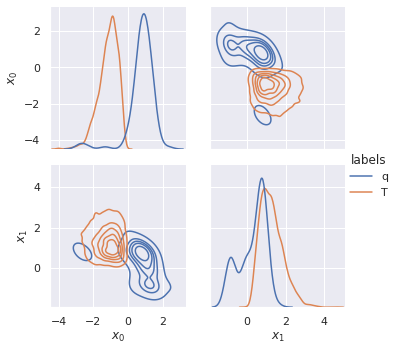

In [64]:
#llk = jax.vmap(lambda x: mh_samples[''])
mh_samples = trace['mh_samples'][0]

samples = mh_samples['DLA_20']
llk = jax.vmap(lambda x: log_like(x))(samples)
lpr = jax.vmap(lambda x: log_prior(x))(samples)

q = q_models['DLA_1']
logq = q.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))
logq = logq.detach().numpy()
logq[logq < lpr] = lpr[logq < lpr]

logw = llk + lpr - logq
#logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.5 * jnp.log(len(logw)))
logw, _ = az.psislw(np.copy(np.asarray(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

sns_pairplot(samples[:, 0:2], np.ones(len(iw)),
             truth_samples=truth_x[:, 0:2], levels=6)